In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Orthogonalization and QR factorization

Given a collection of vectors (columns of a matrix), we can find an orthogonal basis by applying the above procedure one column at a time and saving the result.  Let's think of the first two columns,
$$ \Bigg[ a_0 \, \Bigg| \, a_1 \Bigg] = \Bigg[ q_0 \,\Bigg|\, q_1 \Bigg]
\begin{bmatrix} r_{00} & r_{01} \\ 0 & r_{11} \end{bmatrix} . $$
#### Column 0
The equation for column 0 reads
$$ a_0 = q_0 r_{00} $$
and we require that $\lVert q_0 \rVert = 1$, thus
$$ r_{00} = \lVert a_0 \rVert $$
and
$$ q_0 = a_0 / r_{00} . $$
#### Column 1
This equation reads
$$ a_1 = q_0 r_{01} + q_1 r_{11} $$
where $a_1$ and $q_0$ are known and we will require that $q_0^T q_1 = 0$.
We can find the part of $a_1$ that is orthogonal to $q_0$ via
$$ (I - q_0 q_0^T) a_1 = a_1 - q_0 \underbrace{q_0^T a_1}_{r_{01}} $$
leaving a sub-problem equivalent to that of column 0.

[[ 1.00000000e+00  2.06727448e-17 -7.22457952e-17 -2.05232865e-16]
 [ 2.06727448e-17  1.00000000e+00  1.13635722e-16 -5.08904737e-16]
 [-7.22457952e-17  1.13635722e-16  1.00000000e+00  4.66276733e-17]
 [-2.05232865e-16 -5.08904737e-16  4.66276733e-17  1.00000000e+00]]
4.744563050812836e-16


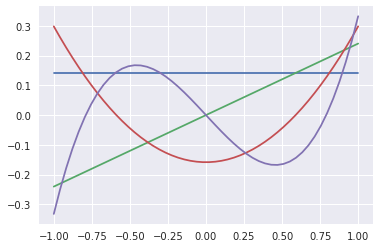

In [3]:
def gram_schmidt_naive(A):
    """Compute a QR factorization of A using the Gram-Schmidt algorithm"""
    Q = np.zeros_like(A)
    R = np.zeros((A.shape[1], A.shape[1]))
    for i in range(len(Q.T)):
        v = A[:,i].copy()
        for j in range(i):
            r = Q[:,j] @ v
            R[j,i] = r
            v -= Q[:,j] * r # "modified Gram-Schmidt"
        R[i,i] = np.linalg.norm(v)
        Q[:,i] = v / R[i,i]
    return Q, R

x = np.linspace(-1, 1)
A = np.vander(x, 4, increasing=True)
Q, R = gram_schmidt_naive(A)
print(Q.T @ Q)
print(np.linalg.norm(Q @ R - A))
plt.plot(x, Q);

### Theorem: all full-rank $m\times n$ matrices ($m \ge n$) have a unique $Q R$ factorization with $R_{j,j} > 0$.


In [4]:
m = 20
V = np.vander(np.linspace(-1,1,m), increasing=True)
Q, R = gram_schmidt_naive(V)

def qr_test(qr, V):
    Q, R = qr(V)
    m = len(Q.T)
    print('{:20} {:.2e} {:.2e}'.format(
        qr.__name__,
        np.linalg.norm(Q @ R - V),
        np.linalg.norm(Q.T @ Q - np.eye(m))))
    
qr_test(gram_schmidt_naive, V)
qr_test(np.linalg.qr, V)

gram_schmidt_naive   9.52e-16 3.04e-09
qr                   2.74e-15 2.39e-15


## Left-looking algorithms: reducing the number of inner products

In [5]:
def gram_schmidt_classical(A):
    Q = np.zeros_like(A)
    R = np.zeros((len(A.T),len(A.T)))
    for i in range(len(Q.T)):
        v = A[:,i].copy()
        R[:i,i] = Q[:,:i].T @ v
        v -= Q[:,:i] @ R[:i,i]
        R[i,i] = np.linalg.norm(v)
        Q[:,i] = v / R[i,i]
    return Q, R

qr_test(gram_schmidt_classical, V)

gram_schmidt_classical 9.14e-16 1.42e+00


Classical Gram-Schmidt is highly parallel, but unstable, as evidenced by the lack of orthogonality in $Q$.

### Right-looking algorithms

The implementations above have been "left-looking"; when working on column $i$, we compare it only to columns to the left (i.e., $j < i$).  We can reorder the algorithm to look to the right by projecting $q_i$ out of all columns $j > i$.  This algorithm is stable while being just as parallel as `gram_schmidt_classical`.

In [28]:
def gram_schmidt_modified(A):
    Q = A.copy()
    R = np.zeros((len(A.T), len(A.T)))
    for i in range(len(Q.T)):
        R[i,i] = np.linalg.norm(Q[:,i])
        Q[:,i] /= R[i,i]
        R[i,i+1:] = Q[:,i].T @ Q[:,i+1:]
        Q[:,i+1:] -= np.outer(Q[:,i], R[i,i+1:])
    return Q, R

qr_test(gram_schmidt_modified, V)

gram_schmidt_modified 8.32e-16 1.32e-08


### Stability

Since QR factorization is unique (with positive diagonal of $R$), if we were to work in exact arithmetic, classical and modified Gram-Schmidt would produce the same result.  Note that modified Gram-Schmidt sequentially applies the projections into the orthogonal complement of each column $q_j$ of $Q$.  That is, given a vector $x$, we sequentially project $(I - q_j q_j^T) x$ for each column $j < i$.  This is equivalent to projecting all those columns at once due to
\begin{align}
  (I - q_1 q_1^T) (I - q_0 q_0^T) x &= \big(I - q_0 q_0^T - q_1 q_1^T + q_1 \underbrace{q_1^T q_0}_{=0} q_0^T \big) x \\
  &= (I - q_0 q_0^T - q_1 q_1^T) x \\
  &= (I - Q Q^T) x
\end{align}
where $Q = [q_0 | q_1 ]$.  This identity can be applied recursively to convert modified Gram-Schmidt to classical, but the identity is not exact in finite precision arithmetic.

norm(v) 1.4245900685395503
r 1.7146698318004178e-07


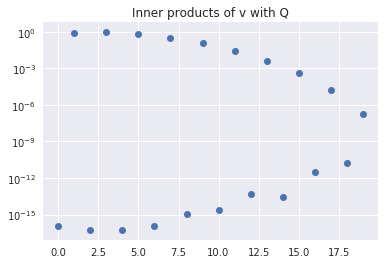

In [7]:
v = V[:,-1]
print('norm(v)', np.linalg.norm(v))
print('r', R[-1,-1])
plt.semilogy(np.abs(Q.T @ v), 'o')
plt.title('Inner products of v with Q');

[1, -0.6666666666666666, -0.22222222222222224, -0.07407407407407408, -0.024691358024691364, -0.008230452674897124, -0.0027434842249657075, -0.0009144947416552361, -0.0003048315805517454, -0.00010161052685058181, -3.3870175616860605e-05, -1.1290058538953536e-05, -3.763352846317846e-06, -1.2544509487726156e-06, -4.181503162575385e-07, -1.3938343875251286e-07, -4.6461146250837626e-08, -1.548704875027921e-08, -5.162349583426404e-09, -1.7207831944754682e-09, -5.735943981584894e-10]
seq   abs 5.9562e-22  rel 2.0768e-12
block abs 5.3534e-17  rel 1.8666e-07
numpy abs 7.4670e-17  rel 2.6036e-07


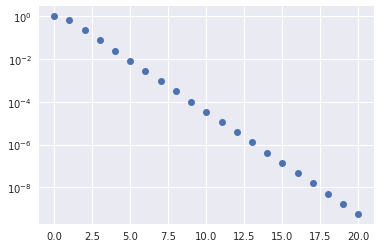

In [8]:
def test_sum(n):
    def gen(first, n, factor=2/3):
        l = [first]
        ifactor = 1-factor
        for i in range(n):
            l.append(-first * factor * ifactor**i)
        return l, first * ifactor**n
    def sum_seq(numbers):
        s = 0
        for a in numbers:
            s += a
        return s
    def sum_block(numbers):
        s = 0
        for a in numbers[1:]:
            s += a
        return numbers[0] + s
    numbers, exact = gen(1, n)
    print(numbers)
    plt.semilogy(np.abs(numbers), 'o')
    seq_err = sum_seq(numbers) - exact
    block_err = sum_block(numbers) - exact
    numpy_err = np.sum(numbers) - exact
    print('seq   abs {:.4e}  rel {:.4e}'.format(seq_err, seq_err/exact))
    print('block abs {:.4e}  rel {:.4e}'.format(block_err, block_err/exact))
    print('numpy abs {:.4e}  rel {:.4e}'.format(numpy_err, numpy_err/exact))
    
test_sum(20)

### Householder triangularization

Gram-Schmidt methods perform triangular transformations to build an orthogonal matrix.  As we have seen, $X = QR$ is satisfied accurately, but $Q$ may not be orthogonal when $X$ is ill-conditioned.  Householder triangularization instead applies a sequence of orthogonal transformations to build a triangular matrix.

$$ \underbrace{Q_{n-1} \dotsb Q_0}_{Q^T} A = R $$

The structure of the algorithm is

$$ \underbrace{\begin{bmatrix} * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ * & * & * \\ \end{bmatrix}}_{A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ 0 & * & * \\ \end{bmatrix}}_{Q_0 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & * \\ 0 & 0 & * \\ \end{bmatrix}}_{Q_1 Q_0 A} \to
\underbrace{\begin{bmatrix} * & * & * \\ 0 & * & * \\ 0 & 0 & * \\ 0 & 0 & 0 \\ 0 & 0 & 0 \\ \end{bmatrix}}_{Q_2 Q_1 Q_0 A}
$$

where the elementary orthogonal matrices $Q_i$ chosen to introduce zeros below the diagonal in the $i$th column of $R$.
Each of these transformations will have the form
$$Q_i = \begin{bmatrix} I_i & 0 \\ 0 & F \end{bmatrix}$$
where $F$ is a "reflection" that achieves
$$ F x = \begin{bmatrix} \lVert x \rVert \\ 0 \\ 0 \\ \vdots \end{bmatrix} $$
where $x$ is the column of $R$ from the diagonal down.
This transformation is a reflection across a plane with normal $v = Fx - x = \lVert x \rVert e_1 - x$.

![Householder Reflector (Trefethen and Bau, 1999)](TB-Householder.png)

The reflection, as depected above by Trefethen and Bau (1999) can be written $F = I - 2 \frac{v v^T}{v^T v}$.

In [9]:
A = np.random.rand(4, 4)
A = A + A.T # Random symmetric matrix
A

array([[1.71984228, 0.68338128, 1.12543662, 0.59188991],
       [0.68338128, 1.5609485 , 1.03109546, 1.4707089 ],
       [1.12543662, 1.03109546, 0.02375504, 0.71686222],
       [0.59188991, 1.4707089 , 0.71686222, 0.88113581]])

In [10]:
A.T - A

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [29]:
from scipy.linalg import block_diag
np.set_printoptions(precision=4)

def reflector(v):
    return np.eye(len(v)) - 2*np.outer(v, v)

v = A[1:,0].copy()
v[0] -= np.linalg.norm(v)
v = v / np.linalg.norm(v)
F = reflector(v)
Q_0 = block_diag(np.eye(1), F)
Q_0

array([[ 1.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.4734,  0.7796,  0.41  ],
       [ 0.    ,  0.7796, -0.1542, -0.607 ],
       [ 0.    ,  0.41  , -0.607 ,  0.6808]])

In [30]:
Q_0 @ A

array([[ 1.7198e+00,  6.8338e-01,  1.1254e+00,  5.9189e-01],
       [ 1.4436e+00,  2.1458e+00,  8.0055e-01,  1.6164e+00],
       [-6.8853e-17,  1.6526e-01,  3.6506e-01,  5.0122e-01],
       [-2.8229e-17,  1.0154e+00,  8.9636e-01,  7.6773e-01]])

In [31]:
A @ Q_0

array([[ 1.7198e+00,  1.4436e+00, -6.8853e-17, -2.8229e-17],
       [ 6.8338e-01,  2.1458e+00,  1.6526e-01,  1.0154e+00],
       [ 1.1254e+00,  8.0055e-01,  3.6506e-01,  8.9636e-01],
       [ 5.9189e-01,  1.6164e+00,  5.0122e-01,  7.6773e-01]])

In [14]:
def householder_Q_times(V, x):
    """Apply orthogonal matrix represented as list of Householder reflectors"""
    y = x.copy()
    for i in reversed(range(len(V))):
        y[i:] -= 2 * V[i] * V[i].dot(y[i:])
    return y

def qr_householder1(A):
    "Compute QR factorization using naive Householder reflection"
    m, n = A.shape
    R = A.copy()
    V = []
    for i in range(n):
        x = R[i:,i]
        v = -x
        v[0] += np.linalg.norm(x)
        v = v/np.linalg.norm(v)     # Normalized reflector plane
        R[i:,i:] -= 2 * np.outer(v, v @ R[i:,i:])
        V.append(v)                    # Storing reflectors is equivalent to storing orthogonal matrix
    Q = np.eye(m, n)
    for i in range(n):
        Q[:,i] = householder_Q_times(V, Q[:,i])
    return Q, np.triu(R[:n,:])

qr_test(qr_householder1, np.array([[1.,2],[3,4],[5,6]]))

qr_householder1      1.88e-15 3.17e-16


In [32]:
qr_test(qr_householder1, V)
qr_test(np.linalg.qr, V)

qr_householder1      3.15e-15 3.48e-15
qr                   2.74e-15 2.39e-15


### Choice of two projections

It turns out our implementation has a nasty deficiency.

In [33]:
qr_test(qr_householder1, np.eye(1))

qr_householder1      nan nan


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [17]:
qr_test(qr_householder1, np.eye(3,2))

qr_householder1      nan nan


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


Inside `qr_householder1`, we have the lines
```
        x = R[i:,i]
        v = -x
        v[0] += numpy.linalg.norm(x)
        v = v/numpy.linalg.norm(v)     # Normalized reflector plane
```
What happens when $$x = \begin{bmatrix}1 \\ 0 \end{bmatrix}$$
(i.e., the column of $R$ is already upper triangular)?

We are trying to define a reflector plane (via its normal vector) from the zero vector,
$$v = \lVert x \rVert e_0 - x .$$
When we try to normalize this vector, we divide zero by zero and the algorithm breaks down (`nan`).  Maybe we just need to test for this special case and "skip ahead" when no reflection is needed?  And if so, how would we define $Q$?

In [18]:
qr_test(qr_householder1, np.array([[1.,1], [2e-8,1]]))
print(qr_householder1(np.array([[1.,1], [2e-8,1]])))

qr_householder1      2.20e-09 4.44e-16
(array([[ 1.0000e+00, -2.2204e-08],
       [ 2.2204e-08,  1.0000e+00]]), array([[1., 1.],
       [0., 1.]]))


The error $QR - A$ is still $10^{-8}$ for this very well-conditioned matrix so something else must be at play here.

![Choosing the better of two Householder reflectors (Trefethen and Bau, 1999).](TB-Householder2.png)

In [34]:
def qr_householder2(A):
    "Compute QR factorization using Householder reflection"
    m, n = A.shape
    R = A.copy()
    V = []
    for i in range(n):
        v = R[i:,i].copy()
        v[0] += np.sign(v[0]) * np.linalg.norm(v) # Choose the further of the two reflections
        v = v/np.linalg.norm(v)     # Normalized reflector plane
        R[i:,i:] -= np.outer(v, 2 * (v.T @ R[i:,i:]))
        V.append(v)                    # Storing reflectors is equivalent to storing orthogonal matrix
    Q = np.eye(m, n)
    for i in range(n):
        Q[:,i] = householder_Q_times(V, Q[:,i])
    return Q, np.triu(R[:n,:])

qr_test(qr_householder2, np.eye(3,2))
qr_test(qr_householder2, np.array([[1.,1], [1e-8,1]]))
for mat in qr_householder2(np.array([[1.,1], [1e-8,1]])):
    print(mat)

qr_test(qr_householder2, V)

qr_householder2      0.00e+00 0.00e+00
qr_householder2      0.00e+00 0.00e+00
[[-1.e+00  1.e-08]
 [-1.e-08 -1.e+00]]
[[-1. -1.]
 [ 0. -1.]]
qr_householder2      5.20e-15 3.58e-15


We now have a usable implementation of Householder QR.  There are some further concerns for factoring rank-deficient matrices.  We will visit the concept of pivoting later, in the context of LU and Cholesky factorization.

## Conditioning

### Absolute condition number
Consider a function $f: X \to Y$ and define the *absolute condition number*
$$ \hat\kappa = \lim_{\delta \to 0} \max_{|\delta x| < \delta} \frac{|f(x + \delta x) - f(x)|}{|\delta x|} = \max_{\delta x} \frac{|\delta f|}{|\delta x|}. $$
If $f$ is differentiable, then $\hat\kappa = |f'(x)|$.

### Floating point arithmetic
Floating point arithmetic $x \circledast y := \text{float}(x * y)$ is exact within a relative accuracy $\epsilon_{\text{machine}}$.  Formally,
$$ x \circledast y = (x * y) (1 + \epsilon) $$
for some $|\epsilon| \le \epsilon_{\text{machine}}$.

In [35]:
eps = 1
while 1 + eps > 1:
    eps /= 2
eps_machine = eps
print('Machine epsilon = {}'.format(eps_machine))
(1 + 1.12e-16) - 1

Machine epsilon = 1.1102230246251565e-16


2.220446049250313e-16

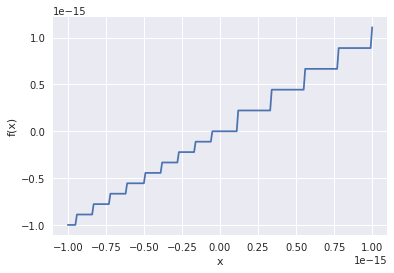

In [36]:
def plot_neighborhood(f, x0, atol=1e-10, rtol=1e-10):
    width = atol + rtol * np.abs(x0)
    x = np.linspace(x0 - width, x0 + width, 201)
    plt.plot(x, f(x))
    plt.xlabel('x')
    plt.ylabel('f(x)')

plot_neighborhood(lambda x: (x + 1) - 1, 0, 1e-15)

This function $f(x) = (x + 1) - 1 = x$ is well conditioned for all $x$, but this numerical algorithm is unstable (we'll discuss this below).

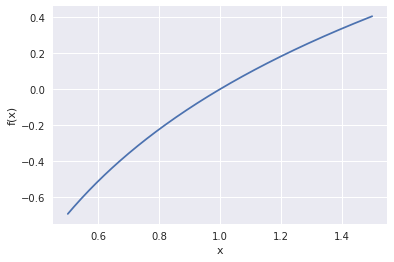

In [23]:
plot_neighborhood(np.log, 1, .5)

The function $f(x) = \log x$ has $f'(1) = 1$.  The conditioning is good in an absolute sense, $\hat \kappa = 1$.  However, the outputs from `np.log(1+x)` have large relative error relative to the exact value, provided here by the function `np.log1p(x)`.

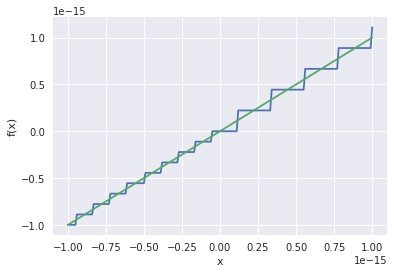

In [24]:
plot_neighborhood(lambda x: np.log(1+x), 0, atol=1e-15)
plot_neighborhood(np.log1p, 0, atol=1e-15)

### Relative condition number

Given the relative nature of floating point arithmetic, it is more useful to discuss **relative condition number**,
$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|}
= \max_{\delta x} \Big[ \frac{|\delta f|/|\delta x|}{|f| / |x|} \Big] $$
or, if $f$ is differentiable,
$$ \kappa = |f'(x)| \frac{|x|}{|f|} . $$

How does a condition number get big?

#### Take-home message

The relative accuracy of the best-case algorithm will not be reliably better than $\epsilon_{\text{machine}}$ times the condition number.
$$ \max_{\delta x} \frac{|\delta f|}{|f|} \ge \kappa \cdot \epsilon_{\text{machine}} .$$

## Stability

We use the notation $\tilde f(x)$ to mean a numerical algorithm for approximating $f(x)$.  Additionally, $\tilde x = x (1 + \epsilon)$ is some "good" approximation of the exact input $x$.

### (Forward) Stability
**"nearly the right answer to nearly the right question"**
$$ \frac{\lvert \tilde f(x) - f(\tilde x) \rvert}{| f(\tilde x) |} \in O(\epsilon_{\text{machine}}) $$
for some $\tilde x$ that is close to $x$

### Backward Stability
**"exactly the right answer to nearly the right question"**
$$ \tilde f(x) = f(\tilde x) $$
for some $\tilde x$ that is close to $x$

* Every backward stable algorithm is stable.
* Not every stable algorithm is backward stable.

### Accuracy of backward stable algorithms (Theorem)

A backward stable algorithm for computing $f(x)$ has relative accuracy
$$ \left\lvert \frac{\tilde f(x) - f(x)}{f(x)} \right\rvert \in O(\kappa(f) \epsilon_{\text{machine}}) . $$
This is a rewording of a statement made earlier -- backward stability is the best case.

### Condition number of a matrix

We may have informally referred to a matrix as "ill-conditioned" when the columns are nearly linearly dependent, but let's make this concept for precise.  Recall the definition of (relative) condition number from the Rootfinding notes,

$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|} . $$

We understood this definition for scalar problems, but it also makes sense when the inputs and/or outputs are vectors (or matrices, etc.) and absolute value is replaced by vector (or matrix) norms.  Let's consider the case of matrix-vector multiplication, for which $f(x) = A x$.

$$ \kappa(A) = \max_{\delta x} \frac{\lVert A (x+\delta x) - A x \rVert/\lVert A x \rVert}{\lVert \delta x\rVert/\lVert x \rVert}
= \max_{\delta x} \frac{\lVert A \delta x \rVert}{\lVert \delta x \rVert} \, \frac{\lVert x \rVert}{\lVert A x \rVert} = \lVert A \rVert \frac{\lVert x \rVert}{\lVert A x \rVert} . $$

There are two problems here:

* I wrote $\kappa(A)$ but my formula depends on $x$.
* What is that $\lVert A \rVert$ beastie?

### Stack push: Matrix norms

Vector norms are built into the linear space (and defined in term of the inner product).  Matrix norms are *induced* by vector norms, according to

$$ \lVert A \rVert = \max_{x \ne 0} \frac{\lVert A x \rVert}{\lVert x \rVert} . $$

* This equation makes sense for non-square matrices -- the vector norms of the input and output spaces may differ.
* Due to linearity, all that matters is direction of $x$, so it could equivalently be written

$$ \lVert A \rVert = \max_{\lVert x \rVert = 1} \lVert A x \rVert . $$

### Stack pop

Now we understand the formula for condition number, but it depends on $x$.  Consider the matrix

$$ A = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} . $$

* What is the norm of this matrix?
* What is the condition number when $x = [1,0]^T$?
* What is the condition number when $x = [0,1]^T$?

The condition number of matrix-vector multiplication depends on the vector.  The condition number of the matrix is the worst case (maximum) of the condition number for any vector, i.e.,

$$ \kappa(A) = \max_{x \ne 0} \lVert A \rVert \frac{\lVert x \rVert}{\lVert A x \rVert} .$$

If $A$ is invertible, then we can rephrase as

$$ \kappa(A) = \max_{x \ne 0} \lVert A \rVert \frac{\lVert A^{-1} (A x) \rVert}{\lVert A x \rVert} =
\max_{A x \ne 0} \lVert A \rVert \frac{\lVert A^{-1} (A x) \rVert}{\lVert A x \rVert} = \lVert A \rVert \lVert A^{-1} \rVert . $$

Evidently multiplying by a matrix is just as ill-conditioned of an operation as solving a linear system using that matrix.

In [37]:
def R_solve(R, b):
    """Solve Rx = b using back substitution."""
    x = b.copy()
    m = len(b)
    for i in reversed(range(m)):
        x[i] -= R[i,i+1:].dot(x[i+1:])
        x[i] /= R[i,i]
    return x

Q, R = np.linalg.qr(A)
x = np.array([1,2,3,4])
bfull = A @ x
breduced = Q.T @ bfull
print(np.linalg.norm(R_solve(R, breduced)
                     - np.linalg.solve(R, breduced)))
R_solve(R, breduced)

4.440892098500626e-16


array([1., 2., 3., 4.])

### Cost of Householder factorization

The dominant cost comes from the line
```Python
    R[i:,i:] -= 2 * numpy.outer(v, v.dot(R[i:,i:]))
```
were `R[i:,i:]` is an $(m-i)\times(n-i)$ matrix.
This line performs $2(m-i)(n-i)$ operations in `v.dot(R[i:,i:])`, another $(m-i)(n-i)$ in the "outer" product and again in subtraction.  As written, multiplication by 2 would be another $(m-i)(n-i)$ operations, but is only $m-i$ operations if we rewrite as
```Python
    w = 2*v
    R[i:,i:] -= numpy.outer(w, v.dot(R[i:,i:]))
```
in which case the leading order cost is $4(m-i)(n-i)$.  To compute the total cost, we need to sum over all columns $i$,
$$\begin{split} \sum_{i=1}^n 4(m-i)(n-i) &= 4 \Big[ \sum_{i=1}^n (m-n)(n-i) + \sum_{i=1}^n (n-i)^2 \Big] \\
&= 4 (m-n) \sum_{i=1}^n i + 4 \sum_{i=1}^n i^2 \\
&\approx 2 (m-n) n^2 + 4 n^3/3 \\
&= 2 m n^2 - \frac 2 3 n^3 .
\end{split}$$
Recall that Gram-Schmidt QR cost $2 m n^2$, so Householder costs about the same when $m \gg n$ and is markedly less expensive when $m \approx n$.

### Backward Stability of Housholder

In [27]:
def qr_test_backward(qr, n):
    from numpy.linalg import norm
    from numpy.random import randn
    R = np.triu(randn(n,n))
    Q, _ = np.linalg.qr(randn(n,n))
    A = Q @ R
    Q2, R2 = qr(A)
    print('# Forward error')
    print('Q error', norm(Q2 - Q))
    print('R error', norm(R2 - R) / norm(R))
    print('# Backward error')
    A2 = Q2 @ R2
    print('Q2.T @ Q2 - I', norm(Q2.T @ Q2 - np.eye(n)))
    print('Q2*R2 - A', norm(A2 - A) / norm(A))
    Q3, R3 = Q + 1e-5*randn(n,n), R + 1e-5*np.triu(randn(n,n))
    A3 = Q3 @ R3
    print('Q3*R3 - A', norm(A3 - A) / norm(A))

qr_test_backward(gram_schmidt_modified, 50)
#qr_test_backward(np.linalg.qr, 50)

# Forward error
Q error 9.380829776561018
R error 1.3114908995362393
# Backward error
Q2.T @ Q2 - I 0.008203364853000912
Q2*R2 - A 2.797766695296299e-16
Q3*R3 - A 7.070141269858638e-05


## Back to parallelism: Cholesky QR (one reduction)

In [9]:
def chol_qr(A):
    import scipy.linalg as la
    B = A.T @ A
    R = la.cholesky(B)
    Q = A @ la.inv(R)
    return Q, R
    
qr_test(chol_qr, V)

chol_qr              8.12e-15 1.07e-01


In [11]:
def chol_qr2(A):
    import scipy.linalg as la
    B = A.T @ A
    R = la.cholesky(B)
    Q = A @ la.inv(R)
    R2 = la.cholesky(Q.T @ Q)
    Q = Q @ la.inv(R2)
    R = R2 @ R
    return Q, R

qr_test(chol_qr2, V)

chol_qr2             8.36e-15 1.29e-15


## TSQR: Tall-Skinny QR

![](ballard-tsqr.png)
Figure from [Ballard et al](https://www.sandia.gov/~gmballa/talks/SIAMPP14.pdf).